In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, InputExample, InputFeatures

# Import Data

In [5]:
df = pd.read_csv("reviews.csv")

In [6]:
train, valid = train_test_split(df, test_size = 0.2, random_state = 42)

In [7]:
train = train.reset_index(drop = True)
valid = valid.reset_index(drop = True)

#Preprocess

In [8]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
    return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=50):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

#Model

In [9]:
# Add some regularization to the model to reduce overfitting
configuration = BertConfig(hidden_dropout_prob = 0.1)

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", config = configuration)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           valid, 
                                                                           'cleaned_text', 
                                                                           'sentiment')

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.batch(128)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(128)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 7)

history = model.fit(train_data, epochs = 20, validation_data = validation_data, callbacks = [callback_1])

Epoch 1/20
35/35 [==============================] - 116s 2s/step - loss: 0.5599 - accuracy: 0.7325 - val_loss: 0.4853 - val_accuracy: 0.7401
Epoch 2/20
35/35 [==============================] - 45s 1s/step - loss: 0.3784 - accuracy: 0.8342 - val_loss: 0.2924 - val_accuracy: 0.8705
Epoch 3/20
35/35 [==============================] - 44s 1s/step - loss: 0.2244 - accuracy: 0.9125 - val_loss: 0.2898 - val_accuracy: 0.8815
Epoch 4/20
35/35 [==============================] - 45s 1s/step - loss: 0.1430 - accuracy: 0.9527 - val_loss: 0.5242 - val_accuracy: 0.8310
Epoch 5/20
35/35 [==============================] - 46s 1s/step - loss: 0.1086 - accuracy: 0.9626 - val_loss: 0.4690 - val_accuracy: 0.8669
Epoch 6/20
35/35 [==============================] - 45s 1s/step - loss: 0.1236 - accuracy: 0.9555 - val_loss: 0.6376 - val_accuracy: 0.8329
Epoch 7/20
35/35 [==============================] - 46s 1s/step - loss: 0.0821 - accuracy: 0.9731 - val_loss: 0.4850 - val_accuracy: 0.8806
Epoch 8/20
35/35 [=

#Evaluation

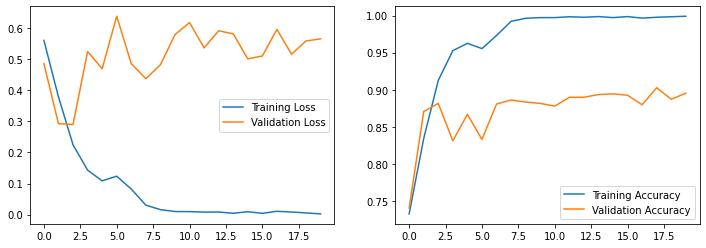

<Figure size 432x288 with 0 Axes>

In [13]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert_accuracy.png')
     

In [14]:
tf_outputs = []
for i in range(int(np.ceil(len(valid) / 128))):
    tf_batch = tokenizer(list(valid["cleaned_text"][i * 128: (i + 1) * 128]), 
                         max_length=50, padding=True, truncation=True, return_tensors='tf')
    tf_outputs += list(model(tf_batch).logits)
tf_predictions = tf.nn.softmax(tf_outputs, axis=-1)
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(valid["cleaned_text"]) // 100):
  print(valid.loc[i, "cleaned_text"], ": \n", str(label[i]))

came home hot morning arizona sun opened illy issimo coffee drink nice cold fridge found expresso taste strong refreshing amount sweetness right great product : 
 1
overall mix okay sugar content high actually see sugar mix look closely pancakes waffles fine savory concoctions acceptable sausage balls casseroles biscuits come almost inedible mix also oddly gritty grit fine still makes teeth want curl recommend pamela baking pancake mix smoother much versatile sweet good cook knows always add something cannot take added much said traveling mix better nothing : 
 1
really good gave people liked plain flavored ones take well using scoops dip salsa eating bbq flavored ones brings back memories yester years would eat bbq pork skins riding back truck range think pepper ones could use pepper still good make good snack side dish lunch cal per pack : 
 1
poor excuse coffee even instant coffee looking forward trying hearing good things web unfortunately disappointed tried coffee using specified 

In [15]:
all_probs = list(map(lambda logit: np.exp(logit) / sum(np.exp(logit)), tf_predictions))
y_prob = list(map(lambda x: x[1], all_probs))

In [16]:
all_probs

[array([0.26900068, 0.73099935], dtype=float32),
 array([0.26906848, 0.7309315 ], dtype=float32),
 array([0.26899767, 0.73100233], dtype=float32),
 array([0.730929  , 0.26907098], dtype=float32),
 array([0.26950428, 0.73049575], dtype=float32),
 array([0.26902127, 0.7309787 ], dtype=float32),
 array([0.730995  , 0.26900497], dtype=float32),
 array([0.73100376, 0.26899618], dtype=float32),
 array([0.7294394, 0.2705606], dtype=float32),
 array([0.27043808, 0.72956187], dtype=float32),
 array([0.2690511 , 0.73094887], dtype=float32),
 array([0.2750501, 0.7249499], dtype=float32),
 array([0.26901293, 0.7309871 ], dtype=float32),
 array([0.2690309, 0.7309691], dtype=float32),
 array([0.3418187, 0.6581813], dtype=float32),
 array([0.26900792, 0.730992  ], dtype=float32),
 array([0.26901773, 0.7309823 ], dtype=float32),
 array([0.2690445 , 0.73095554], dtype=float32),
 array([0.2689964 , 0.73100364], dtype=float32),
 array([0.26975384, 0.7302461 ], dtype=float32),
 array([0.55514514, 0.444854

In [17]:
y_scores = list(map(lambda prob: prob[1], all_probs))
precision, recall, thresholds = precision_recall_curve(valid["sentiment"], y_scores)

In [18]:
auc(recall, precision)

0.9704050908221027

Text(0.5, 1.0, 'Precision-Recall Curve')

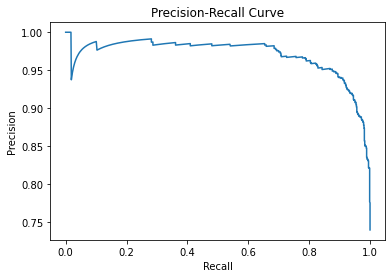

In [19]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve")

In [26]:
tf.saved_model.save(model, "best_model")

In [27]:
model2 = tf.keras.models.load_model("best_model")

In [34]:
tf_outputs = []
for i in range(int(np.ceil(len(valid) / 128))):
    tf_batch = tokenizer(list(valid["cleaned_text"][i * 128: (i + 1) * 128]), 
                         max_length=50, padding=True, truncation=True, return_tensors='tf')
    tf_outputs += list(model2(tf_batch)["logits"])
tf_predictions = tf.nn.softmax(tf_outputs, axis=-1)
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(valid["cleaned_text"]) // 100):
  print(valid.loc[i, "cleaned_text"], ": \n", str(label[i]))

came home hot morning arizona sun opened illy issimo coffee drink nice cold fridge found expresso taste strong refreshing amount sweetness right great product : 
 1
overall mix okay sugar content high actually see sugar mix look closely pancakes waffles fine savory concoctions acceptable sausage balls casseroles biscuits come almost inedible mix also oddly gritty grit fine still makes teeth want curl recommend pamela baking pancake mix smoother much versatile sweet good cook knows always add something cannot take added much said traveling mix better nothing : 
 1
really good gave people liked plain flavored ones take well using scoops dip salsa eating bbq flavored ones brings back memories yester years would eat bbq pork skins riding back truck range think pepper ones could use pepper still good make good snack side dish lunch cal per pack : 
 1
poor excuse coffee even instant coffee looking forward trying hearing good things web unfortunately disappointed tried coffee using specified 